In [133]:
import cenpy
import contextily as ctx 
import segregation
%matplotlib inline
import matplotlib as mpl

In [134]:
import xyzservices.providers as xyz
import matplotlib.pyplot as plt #to make sure there are no errors when plotting a graph
from contextily import add_basemap
import folium 

In [135]:
import geopandas as gpd 
from census import Census 
from us import states
from shapely.geometry import Polygon

In [136]:
import pandas as pd

In [137]:
from contextily import Place


**Census Api**

In [138]:
acs=cenpy.products.ACS(year="latest")  
acs.filter_tables('POPULATION', by='description')


,description,columns
table_name,,
B01003,TOTAL POPULATION,[B01003_001E]
B05006,PLACE OF BIRTH FOR THE FOREIGN-BORN POPULATION...,"[B05006_001E, B05006_002E, B05006_003E, B05006..."
B05007,PLACE OF BIRTH BY YEAR OF ENTRY BY CITIZENSHIP...,"[B05007_001E, B05007_002E, B05007_003E, B05007..."
B05008,SEX BY PLACE OF BIRTH BY YEAR OF ENTRY FOR THE...,"[B05008_001E, B05008_002E, B05008_003E, B05008..."
B05013,SEX BY AGE FOR THE FOREIGN-BORN POPULATION,"[B05013_001E, B05013_002E, B05013_003E, B05013..."
...,...,...
C24030,SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...,"[C24030_001E, C24030_002E, C24030_003E, C24030..."
C24040,"SEX BY INDUSTRY FOR THE FULL-TIME, YEAR-ROUND ...","[C24040_001E, C24040_002E, C24040_003E, C24040..."
C24050,INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLO...,"[C24050_001E, C24050_002E, C24050_003E, C24050..."


In [139]:
c = Census('f5e7cf46eaa83ae8323e6051f74d9ab363d0b957')

In [140]:
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
bxr_householder_by_race = c.acs5.state_county_tract(fields = ('NAME', 'B25006_001E', # All Race of Householders
                                                                'B25006_003E', # Black Race of Householders
                                                                ), 
                                      state_fips = states.TX.fips, 
                                      county_fips = "029",
                                      tract = "*",
                                      year = 2009)

In [141]:
bxr_hh_race_df = pd.DataFrame(bxr_householder_by_race)

In [142]:
print(bxr_hh_race_df.head(2))
print('Shape: ', bxr_hh_race_df.shape)

                                     NAME  B25006_001E  B25006_003E state  \
0  Census Tract 1101, Bexar County, Texas       1280.0         44.0    48   
1  Census Tract 1102, Bexar County, Texas        258.0         33.0    48   

  county   tract  
0    029  110100  
1    029  110200  
Shape:  (278, 6)


access shapefile of bexar county. this will coordinate data and alignment with Mercator projection

In [143]:
bxr_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_48_tract.zip")


In [144]:
print(bxr_census_tract.head(2))

print('Shape: ', bxr_census_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(bxr_census_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      48      439  121609  48439121609  1216.09  Census Tract 1216.09  G5020   
1      48      187  210708  48187210708  2107.08  Census Tract 2107.08  G5020   

  FUNCSTAT    ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  4036421  2474977  +32.6893777  -097.2140987   
1        S  2625635        0  +29.5747421  -098.2516707   

                                            geometry  
0  POLYGON ((-97.23369 32.67175, -97.23366 32.671...  
1  POLYGON ((-98.26254 29.57872, -98.26236 29.578...  
Shape:  (5265, 13)

The shapefile projection is: epsg:4269


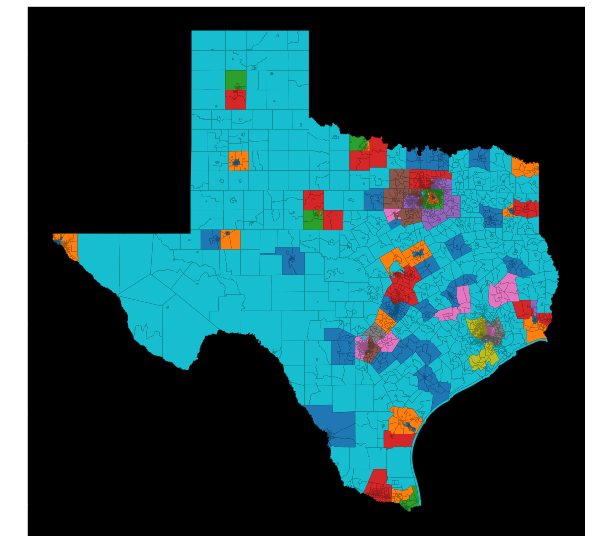

In [145]:
bxr_census_tract.plot('TRACTCE', legend=False, figsize=(10,10))

plt.style.use('dark_background')



performing dataframe operations= https://pygis.io/docs/e_vector_merge_dissolve.html

In [146]:
# Combine state, county, and tract columns together to create a new string and assign to new column
bxr_hh_race_df["GEOID"] = bxr_hh_race_df["state"] + bxr_hh_race_df["county"] + bxr_hh_race_df["tract"]

In [147]:
bxr_hh_race_df.head(2)

,NAME,B25006_001E,B25006_003E,state,county,tract,GEOID
0,"Census Tract 1101, Bexar County, Texas",1280.0,44.0,48,029,110100,48029110100
1,"Census Tract 1102, Bexar County, Texas",258.0,33.0,48,029,110200,48029110200


In [148]:
# Remove columns
bxr_hh_race_df = bxr_hh_race_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
bxr_hh_race_df.head(2)

,NAME,B25006_001E,B25006_003E,GEOID
0,"Census Tract 1101, Bexar County, Texas",1280.0,44.0,48029110100
1,"Census Tract 1102, Bexar County, Texas",258.0,33.0,48029110200


check column data types 

In [149]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(bxr_hh_race_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(bxr_census_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
B25006_001E    float64
B25006_003E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


merge dataframes

In [150]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
bxr_merge = bxr_census_tract.merge(bxr_hh_race_df, on = "GEOID")

# Show result
print(bxr_merge.head(2))
print('Shape: ', bxr_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x           NAMELSAD  MTFCC  \
0      48      029  121000  48029121000   1210  Census Tract 1210  G5020   
1      48      029  190700  48029190700   1907  Census Tract 1907  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  6640253   33515  +29.5322204  -098.4454653   
1        S  1461126       0  +29.4774628  -098.4955937   

                                            geometry  \
0  POLYGON ((-98.46917 29.51845, -98.46904 29.518...   
1  POLYGON ((-98.49932 29.47243, -98.49929 29.472...   

                                   NAME_y  B25006_001E  B25006_003E  
0  Census Tract 1210, Bexar County, Texas       3005.0         91.0  
1  Census Tract 1907, Bexar County, Texas       1353.0        106.0  
Shape:  (194, 16)


Subset dataframe. working with bxr_merge shapefile

In [151]:
# Create new dataframe from select columns
bxr_hh_race_tract = bxr_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "B25006_001E", "B25006_003E"]]

# Show dataframe
print(bxr_hh_race_tract.head(2))
print('Shape: ', bxr_hh_race_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      48      029  121000  48029121000   
1      48      029  190700  48029190700   

                                            geometry  B25006_001E  B25006_003E  
0  POLYGON ((-98.46917 29.51845, -98.46904 29.518...       3005.0         91.0  
1  POLYGON ((-98.49932 29.47243, -98.49929 29.472...       1353.0        106.0  
Shape:  (194, 7)


In [152]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
bxr_hh_race_county = bxr_hh_race_tract.dissolve(by = 'TRACTCE', aggfunc = 'mean')

# Show dataframe
print(bxr_hh_race_county.head())
print('Shape: ', bxr_hh_race_county.shape)

                                                  geometry  B25006_001E  \
TRACTCE                                                                   
110100   POLYGON ((-98.50150 29.43284, -98.50141 29.432...       1280.0   
110300   POLYGON ((-98.48951 29.41564, -98.48907 29.415...       1161.0   
110500   POLYGON ((-98.51493 29.41416, -98.51486 29.414...        779.0   
110600   POLYGON ((-98.51382 29.42267, -98.51381 29.422...       1142.0   
110700   POLYGON ((-98.51508 29.44412, -98.51496 29.444...        590.0   

         B25006_003E  
TRACTCE               
110100          44.0  
110300         131.0  
110500          44.0  
110600           0.0  
110700          35.0  
Shape:  (194, 3)


In [153]:
# Get householder by race rate and store values in new column
bxr_hh_race_county['Percentage'] = (bxr_hh_race_county["B25006_003E"]/bxr_hh_race_county["B25006_001E"])*100


# Show dataframe
bxr_hh_race_county.head(10)  

,geometry,B25006_001E,B25006_003E,Percentage
TRACTCE,,,,
110100,"POLYGON ((-98.50150 29.43284, -98.50141 29.432...",1280.0,44.0,3.437500
110300,"POLYGON ((-98.48951 29.41564, -98.48907 29.415...",1161.0,131.0,11.283376
110500,"POLYGON ((-98.51493 29.41416, -98.51486 29.414...",779.0,44.0,5.648267
110600,"POLYGON ((-98.51382 29.42267, -98.51381 29.422...",1142.0,0.0,0.000000
110700,"POLYGON ((-98.51508 29.44412, -98.51496 29.444...",590.0,35.0,5.932203
110800,"POLYGON ((-98.49936 29.44703, -98.49836 29.447...",896.0,110.0,12.276786
110900,"POLYGON ((-98.48973 29.43855, -98.48874 29.439...",170.0,0.0,0.000000
111000,"POLYGON ((-98.48010 29.43690, -98.47996 29.437...",812.0,72.0,8.866995
120100,"POLYGON ((-98.47386 29.44534, -98.47362 29.445...",760.0,213.0,28.026316


In [154]:
import rasterio
from rasterio.plot import show as rioshow
from contextily.tile import warp_img_transform, warp_tiles, _warper

In [155]:
import fiona
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

In [156]:
bxr_hh_race_county.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

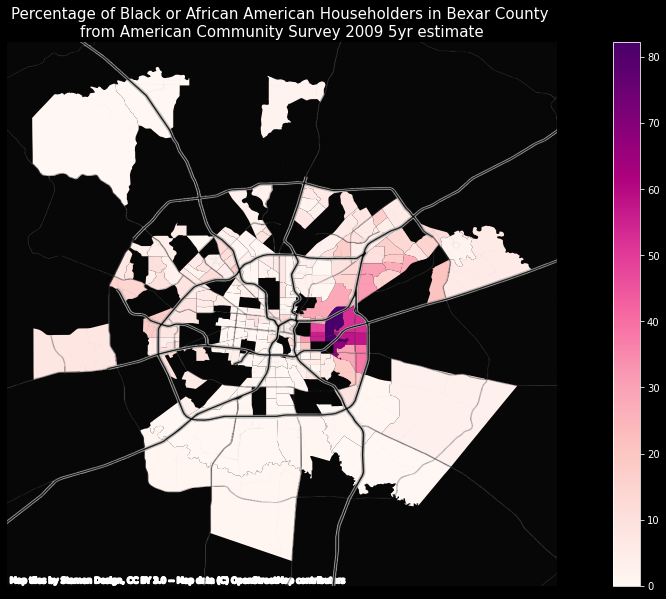

In [160]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html

bxr_plot = bxr_hh_race_county.plot('Percentage', 
                       ax = ax,
                       cmap = "RdPu",
                       legend = True
                        )

ctx.Place("Bexar County, TX")
ctx.add_basemap(ax, zoom='auto', crs=4269, source=ctx.providers.Stamen.TonerLines, alpha=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, zoom=10)

ax.set_axis_off()

# Stylize plots
#plt.style.use('dark_background')

ax.set_facecolor('white')

ax.grid(visible=None) #remove grid lines 

# Set title
ax.set_title('Percentage of Black or African American Householders in Bexar County \nfrom American Community Survey 2009 5yr estimate', fontdict = {'fontsize': '15', 'fontweight' : '3'})

ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

In [158]:
bxr_plot.to_fi

AttributeError: 'AxesSubplot' object has no attribute 'to_fi'

In [ ]:
#ctx.add_basemap(ax, crs= 4269, url='http://maps.stamen.com/m2i/#terrain/1000:1000/10/29.4297/-98.5266', alpha=.50, zoom=18)
#ctx.add_basemap(ax, crs=4269, source=ctx.providers.Stamen.TonerLabels, alpha=.90, zoom='auto', attribution_size=12)
#ax.set_axis_off()